In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [54]:
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X

,htreat,age,menostat,tumsize,tumgrad,posnodal,prm,esm
0,0,70,2,21,2,3,48,66
1,1,56,2,12,2,7,61,77
2,1,58,2,35,2,9,52,271
3,1,59,2,17,2,4,60,29
4,0,73,2,35,2,1,26,65
...,...,...,...,...,...,...,...,...
681,0,49,1,30,3,3,1,84
682,1,53,2,25,3,17,0,0
683,0,51,1,25,3,5,43,0
684,0,52,2,23,2,3,15,34


In [55]:
# X = X[["max_ESR", "gender", "age"]].dropna()
# X["ref_ESR"] = X["max_ESR"] < 20
# X = X[(X["gender"] == 1) & (X["age"] > 50)].reset_index()
# y = y[X.index]

# feat = "ref_ESR"  # Wuhan

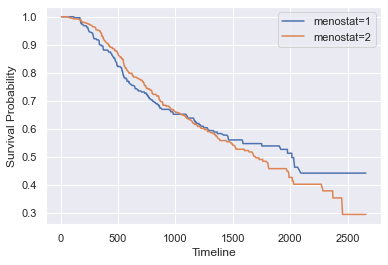

In [56]:
feat = "menostat"  # GBSG (menostat)
# feat = "sex"  # PBC

bins = np.unique(y["time"])

fig = plt.figure()
for v in np.unique(X[feat]):
    index = X.query(f"{feat} == {v}").index
    
    kmf = KaplanMeierFitter()
    kmf.fit(y[index]['time'], event_observed=y[index]['cens'])
    sf_train = kmf.survival_function_at_times(bins).to_numpy()
    plt.plot(bins, sf_train, label=f"{feat}={v}")
plt.ylabel("Survival Probability")
plt.xlabel("Timeline")
plt.legend()

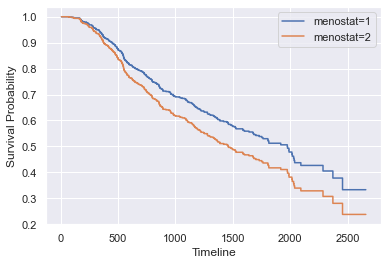

In [57]:
from lifelines import CoxPHFitter
df = X.copy()  # [[feat]]
df["time"] = y["time"]
df["cens"] = y["cens"]

cph = CoxPHFitter().fit(df, 'time', 'cens')  # strata=[feat]
cph.plot_partial_effects_on_outcome(feat, plot_baseline=False, 
                                    values=np.unique(X[feat]))
plt.ylabel("Survival Probability")
plt.xlabel("Timeline")
plt.legend()

In [58]:
plt.figure(figsize=(14, 7))
cph.check_assumptions(df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
         test_name = proportional_hazard_test

---
               test_statistic    p  -log2(p)
age      km              2.78 0.10      3.39
         rank            2.65 0.10      3.27
esm      km              0.91 0.34      1.56
         rank            1.32 0.25      2.00
htreat   km              0.17 0.68      0.55
         rank            0.17 0.68      0.55
menostat km              0.01 0.92      0.13
         rank            0.03 0.87      0.20
posnodal km              0.72 0.40      1.34
         rank            0.70 0.40      1.31
prm      km              1.39 0.24      2.07
         rank            1.25 0.26      1.92
tumgrad  km              4.43 0.04      4.82
         rank            5.57 0.02      5.78
tumsize  km              0.24 0.62      0.68
         rank            0.24 0.62      0.68



1. Variable 'tumgrad' failed the non-proportional test: p-value is 0.0182.

   Advice: with so few unique values (only 3), you can include `strata=['tumgrad', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

<Figure size 1008x504 with 0 Axes>

In [52]:
from typing import List, Optional, Dict, Any, Iterable
from textwrap import dedent, fill
from autograd import numpy as anp
import numpy as np
from pandas import DataFrame, Series
from lifelines.statistics import proportional_hazard_test, TimeTransformers
from lifelines.utils import format_p_value
from lifelines.utils.lowess import lowess


def plot_assumptions(cph,
        training_df: DataFrame,
        p_value_threshold: float = 0.01,
        plot_n_bootstraps: int = 15,
        columns: Optional[List[str]] = None):    
    residuals = cph.compute_residuals(training_df, kind="scaled_schoenfeld")
    test_results = proportional_hazard_test(cph, training_df, time_transform=["rank", "km"], precomputed_residuals=residuals)

    residuals_and_duration = residuals.join(training_df[cph.duration_col])
    Xs = cph.regressors.transform_df(training_df)

    counter = 0
    n = residuals_and_duration.shape[0]
    axes = []

    for variable in cph.params_.index.intersection(columns or cph.params_.index):
        minumum_observed_p_value = test_results.summary.loc[variable, "p"].min()
        if np.round(minumum_observed_p_value, 2) > p_value_threshold:
            continue
        counter += 1
        # show plots
        axes.append([])
        fig = plt.figure(figsize=(14, 7))

        # plot variable against all time transformations.
        for i, (transform_name, transformer) in enumerate(TimeTransformers().iter(["rank", "km"]), start=1):
            p_value = test_results.summary.loc[(variable, transform_name), "p"]

            ax = fig.add_subplot(1, 2, i)

            y = residuals_and_duration[variable]
            tt = transformer(cph.durations, cph.event_observed, cph.weights)[cph.event_observed.values]

            ax.scatter(tt, y, alpha=0.75)

            y_lowess = lowess(tt.values, y.values)
            ax.plot(tt, y_lowess, color="k", alpha=1.0, linewidth=2)

            # bootstrap some possible other lowess lines. This is an approximation of the 100% confidence intervals
            for _ in range(plot_n_bootstraps):
                ix = sorted(np.random.choice(n, n))
                tt_ = tt.values[ix]
                y_lowess = lowess(tt_, y.values[ix])
                ax.plot(tt_, y_lowess, color="k", alpha=0.30)

            best_xlim = ax.get_xlim()
            ax.hlines(0, 0, tt.max(), linestyles="dashed", linewidths=1)
            ax.set_xlim(best_xlim)

            ax.set_xlabel("%s-transformed time\n(p=%.4f)" % (transform_name, p_value), fontsize=13)
            axes[-1].append(ax)

        fig.suptitle("Scaled Schoenfeld residuals of '%s'" % variable, fontsize=14)
        plt.tight_layout()
#         plt.subplots_adjust(top=0.90)

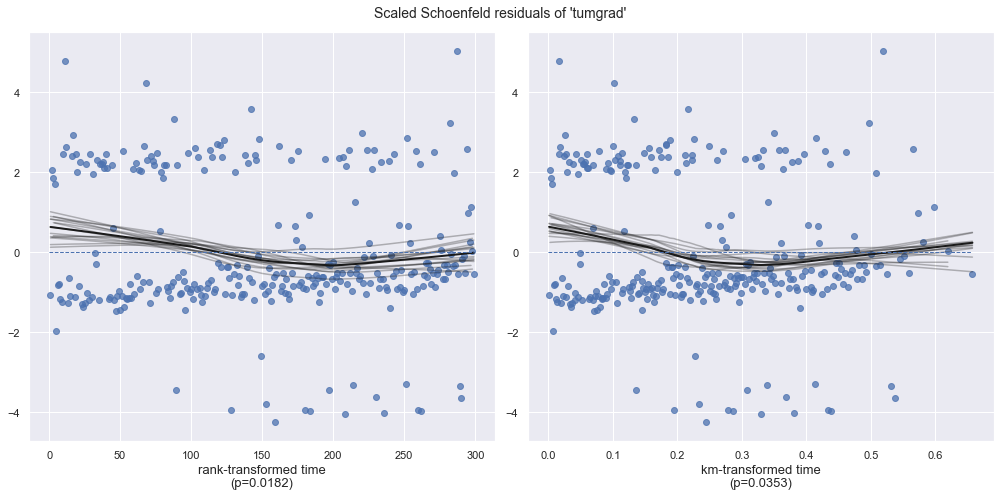

In [62]:
plot_assumptions(cph, df, p_value_threshold=0.05)

### Лучшее разбиение

In [118]:
# X, y, features, categ, sch_nan = ds.load_pbc_dataset()
X, y, features, categ, sch_nan = ds.load_onk_dataset()
X

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}


,Вес,Рост,Пол,Возраст,Стадия,Tumor_опухоль,Nodus_узлы,Метастазы,MTSTZ,Индекс_массы,...,Пред_лечение_Лекарственная_противоопухолевая_терапия_Неоадъювантная,Пред_лечение_Лекарственная_противоопухолевая_терапия_Адъювантная,Пред_лечение_Лекарственная_противоопухолевая_терапия_Периоперационная_до_хирургического_лечения,Пред_лечение_Лекарственная_противоопухолевая_терапия_Периоперационная_после_хирургического_лечения,Пред_лечение_Лучевая_терапия_Первичной_опухоли_ложа_опухоли,Пред_лечение_Лучевая_терапия_Метастазов,Пред_лечение_Лучевая_терапия_Симптоматическая,Пред_лечение_Химиолучевая_терапия,Пред_лечение_Неспецифическое_лечение,Пред_лечение_Диагностика
0,NaN,NaN,1.0,62.0,3.0,4.0,1.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,1.0,64.0,3.0,4.0,1.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,1.0,66.0,2.0,3.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60.0,170.0,1.0,55.0,3.0,3.0,1.0,0.0,NaN,35.294118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,58.0,176.0,1.0,62.0,3.0,4.0,1.0,0.0,0.0,32.954545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3376,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3377,NaN,NaN,NaN,NaN,2.0,2.0,NaN,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3378,NaN,NaN,NaN,NaN,3.0,3.0,NaN,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
df = X[features[:20]].copy()
df[cnt.TIME_NAME] = y[cnt.TIME_NAME]
df[cnt.CENS_NAME] = y[cnt.CENS_NAME]

In [125]:
def plot_km_with_ibs(data, label):
    bins = cnt.get_bins(data[cnt.TIME_NAME].values, 
                        cens=data[cnt.CENS_NAME].values)
    kmf = KaplanMeierFitter()
    kmf.fit(data[cnt.TIME_NAME], 
            event_observed=data[cnt.CENS_NAME])
    sf_train = kmf.survival_function_at_times(bins).to_numpy()
    pred_sf = np.repeat(sf_train[np.newaxis, :], data.shape[0], axis=0)
    true_sf = cnt.get_y(data[cnt.CENS_NAME], data[cnt.TIME_NAME])
    ibs_val = round(metr.ibs(true_sf, true_sf, pred_sf, bins), 5)
    plt.plot(bins, sf_train, label=f"{label}: SIZE={data.shape[0]}, IBS={ibs_val}")

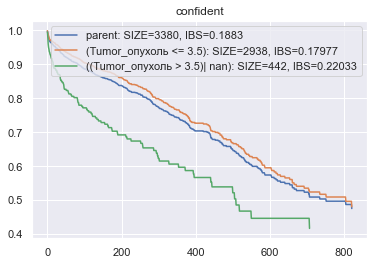

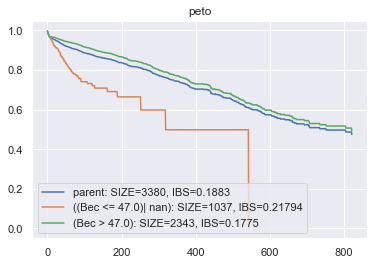

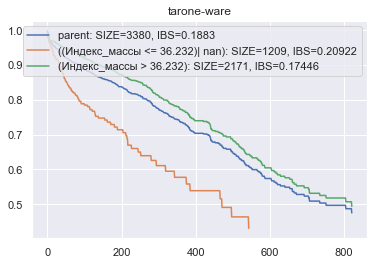

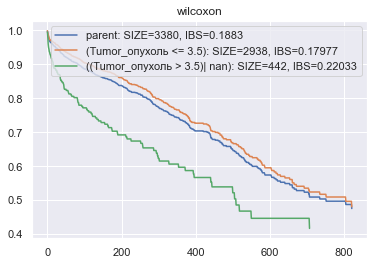

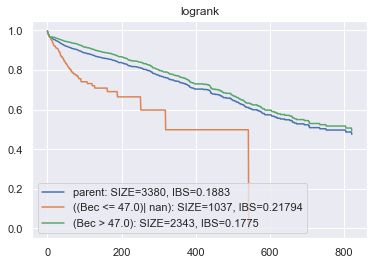

In [126]:
from survivors.tree import Node
# from survivors.tree.find_split_hist import hist_best_attr_split

for crit in ["confident", "peto", "tarone-ware", "wilcoxon", "logrank"]:
    n = Node(df, features=df.columns[:-2], criterion=crit, min_samples_leaf=1, signif=0.01)
    subnodes = n.split()
    
    plot_km_with_ibs(n.df, "parent")
    plot_km_with_ibs(subnodes[0].df, f"{subnodes[0].full_rule[0].to_str()}")
    plot_km_with_ibs(subnodes[1].df, f"{subnodes[1].full_rule[0].to_str()}")
    plt.legend()
    plt.title(crit)
    plt.show()